In [36]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # parallel independent sequences to process in a time
block_size = 32 # maximum content length for predictions
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(42)

# download the data from my github
#https://raw.githubusercontent.com/rabiaedayilmaz/karpathy-youtube-videos/main/lesson7-gpt/tutunamayanlar-oguz-atay.txt

# load the data
with open("/content/tutunamayanlar-oguz-atay.txt") as f:
  text = f.read()

# all the unique characters
chars = sorted(list(set(text)))
vocab_size = len(chars)

# mapping between chars and ints
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# encoder function
encode = lambda s: [char_to_int[c] for c in s]
# decoder function
decode = lambda l: "".join([int_to_char[i] for i in l])

# split to train and val
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # %90 train
train_data = data[:n]
val_data = data[n:]

# data loading via batches
def get_batch(split):
  data = train_data if split == "train" else val_data
  ix = torch.randint(len(data) - block_size, (batch_size, ))
  x = torch.stack([data[i: i+block_size] for i in ix])
  y = torch.stack([data[i+1: i+block_size+1] for i in ix])
  x, y = x.to(device), y.to(device)
  return x, y

@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ["train", "val"]:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, y = get_batch(split)
      logits, loss = model(X, y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x) # (B, T, C)
    q = self.query(x) # (B, T, C)
    # compute attention scores
    wei = q @ k.transpose(-2, -1) * C ** -0.5 # (B, T, C) @ (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B, T, T)
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    # perform weighted aggregation of the values
    v = self.value(x) # (B, T, C)
    out = wei @ v # (B, T, T) @ (B, T, C) --> (B, T, C)
    return out

class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)
  
  def forward(self, idx, targets=None):
    B, T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B, T, C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
    x = tok_emb + pos_emb # (B, T, C) - broadcasting
    x = self.blocks(x) # (B, T, C)
    x = self.ln_f(x) # (B, T, C)
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:] # crop idx to last block_size
      logits, loss = self(idx_cond) # get predictions
      logits = logits[:, -1, :] # logits -> (B, T, C). focus on last time step -> (B, C)
      probs = F.softmax(logits, dim=-1) # get probabilities
      idx_next = torch.multinomial(probs, num_samples=1) # sample from distribution
      idx = torch.cat((idx, idx_next), dim=1) # append sampled idx_next to running sequence idx
    return idx

model = BigramLanguageModel()
m = model.to(device)
# number of parameters
print(sum(p.numel() for p in m.parameters())/1e6, "M parameters.")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


train_hist, val_hist = [], []
for iter in range(max_iters):
  if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    train_hist.append(losses["train"])
    val_hist.append(losses["val"])
    print(f"step: {iter} train loss: {losses['train']:.4f} val loss: {losses['val']:.4f}")
  
  # sample a batch
  xb, yb = get_batch("train")

  # evaluation of loss
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print("[INFO] Model is trained!\n")

0.213857 M parameters.
step: 0 train loss: 4.7564 val loss: 4.7535
step: 100 train loss: 2.7065 val loss: 2.6872
step: 200 train loss: 2.5296 val loss: 2.5224
step: 300 train loss: 2.4008 val loss: 2.3901
step: 400 train loss: 2.3113 val loss: 2.3087
step: 500 train loss: 2.2619 val loss: 2.2486
step: 600 train loss: 2.2159 val loss: 2.2085
step: 700 train loss: 2.1842 val loss: 2.1518
step: 800 train loss: 2.1516 val loss: 2.1060
step: 900 train loss: 2.1358 val loss: 2.0944
step: 1000 train loss: 2.1006 val loss: 2.0830
step: 1100 train loss: 2.0815 val loss: 2.0397
step: 1200 train loss: 2.0521 val loss: 2.0331
step: 1300 train loss: 2.0256 val loss: 2.0050
step: 1400 train loss: 2.0229 val loss: 1.9859
step: 1500 train loss: 1.9945 val loss: 1.9661
step: 1600 train loss: 1.9888 val loss: 1.9465
step: 1700 train loss: 1.9691 val loss: 1.9400
step: 1800 train loss: 1.9552 val loss: 1.9330
step: 1900 train loss: 1.9418 val loss: 1.9182
step: 2000 train loss: 1.9188 val loss: 1.9020
st

In [37]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


zalada. Geçip onlar, olusunurdu yolarlak. Gerçekkeyenler ve günen
biçle bir de şişlerde
bıraktık. Oyne orada Talp yengil saderemeklerindikten ön-
denik biçirt”iz dedi sözlerin-
leri
nimle, işmeye neredir middileri olamadığını geçmeneniklerce, ocudur: ‘Hembrizlerdi,
  Dedöndüklerimizasını sizdi.




  Selim) sıkardı. Oraçalı yaparılantmış için
şira kitap teh düşüncelerden yöndüsünüverdiğime güç-
lümüzdeceklerinle Adaman için ağmayı mı?” Bir niden kendi ihratti seyğini babaşladı da tanıkkaradaştı bir deren yelinonlarını zoruk iki bulan olduk fonza hayvayım yanıyorumduya bizimli döğtlerden sözendir her harafikmeler.”
 “MA0 alimeleri, hep bir şeyir
yapdılaktı olduğu konuzdu. Türkküyu de-
n düzean edkim sizinin şey şekil demekse
giyece çerimesiyle
bir yoki. Elledi meneler. Türktere kayfada kereşisini içmez yetin azalımkele-
ceğini-
miz, daha benzemez
birlikten olduğu kadanlım.
Telli susurduğun rarçık kaybir hükütü Miharlık ona ora-
lanma da baskaydık. Öylece, sonra?” dışıntıma dore-
de taz

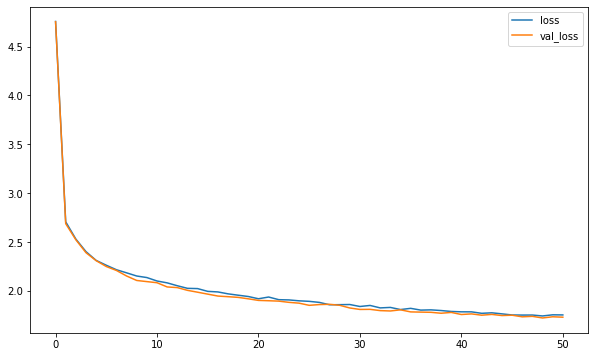

In [39]:
# plot the results
import matplotlib.pyplot as plt

assert len(train_hist) == len(val_hist), "Length of logs of train and val loss must be the same."

eps = range(len(train_hist))
plt.figure(figsize=(10, 6))
plt.plot(eps, train_hist)
plt.plot(eps, val_hist)
plt.legend(["loss", "val_loss"])